# Imports

In [2]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning) 
warnings.filterwarnings("ignore", category=SyntaxWarning) 

In [3]:
import nibabel as nib
import numpy as np
import pandas as pd
import math
from nilearn import image as nimg
from nilearn import plotting as nplot
from nilearn import masking as nimask
from matplotlib import pyplot as plt
import seaborn as sns
from tqdm import tqdm
import pickle
import math 
import os
from scripts.eda_func import *

# Define what data to use

In [4]:
#Define what data to use
data_folder = 'ADHD200_7'

#If a mac
mac = True
path_addon = '.nosync' if mac == True else ''

#Regions
num_of_regions = 7
regions = [f"ROI_{i+1}" for i in range(num_of_regions)]

# Read in the data

In [5]:
#Just run ones
#mean, var = get_mean_and_var_stats(data_folder = 'ADHD200_7', 
#                                   mac = True)

#Load mean and variance
mean_pr_roi = pd.read_csv(f'data{path_addon}/stats/{data_folder}_mean_subject.csv', 
                          sep = ';',
                          index_col = 'Unnamed: 0')
var_pr_roi = pd.read_csv(f'data{path_addon}/stats/{data_folder}_variance_subject.csv', 
                         sep = ';',
                         index_col = 'Unnamed: 0')

#Expand subject ID
mean_pr_roi['Subject_ID'] = mean_pr_roi['Subject_ID'].apply(lambda x: ''.join(['0' for i in range(7-len(str(x)))]) + str(x))
#Expand subject ID
var_pr_roi['Subject_ID'] = var_pr_roi['Subject_ID'].apply(lambda x: ''.join(['0' for i in range(7-len(str(x)))]) + str(x))

print('Mean Shape:', mean_pr_roi.shape)
print('Variance Shape:', var_pr_roi.shape)

Mean Shape: (394, 10)
Variance Shape: (394, 10)


### Add extra meta data

In [6]:
meta_data = pd.read_csv('data.nosync/phenotypic/ADHD200_phenotypic.csv')
#Expand subject ID
meta_data['ScanDir ID'] = meta_data['ScanDir ID'].apply(lambda x: ''.join(['0' for i in range(7-len(str(x)))]) + str(x))
#Select columns
meta_data = meta_data[['ScanDir ID', 'Gender', 'DX']]
#Replace values
meta_data['DX'] = meta_data['DX'].replace({0: 'TD', 1: 'ADHD-Combined', 2: 'ADHD-Hyperactive/Impulsive', 3: 'ADHD-Inattentive'})
meta_data['Gender'] = meta_data['Gender'].replace({0: 'Female', 1: 'Male'})

meta_data = meta_data.drop_duplicates('ScanDir ID')

#Merge with scans
mean_pr_roi = pd.merge(left = mean_pr_roi, 
                        right = meta_data,
                        left_on= 'Subject_ID',
                        right_on= 'ScanDir ID')

var_pr_roi = pd.merge(left = var_pr_roi, 
                        right = meta_data,
                        left_on= 'Subject_ID',
                        right_on= 'ScanDir ID')

# EDA

## Describe the data

### Gender & Diagnosis

In [7]:
print('Number of unique subjects:', len(mean_pr_roi['Subject_ID'].unique()))
print('=' * 30)
print('Scanes from males:', mean_pr_roi['Gender'].value_counts()[0])
print('Scanes from females:', mean_pr_roi['Gender'].value_counts()[1])
print('=' * 30)
print('Number of TD scans:', mean_pr_roi['DX'].value_counts()[0])
print('Number of ADHD-Combined scans:', mean_pr_roi['DX'].value_counts()[1])
print('Number of ADHD-Inattentive scans:', mean_pr_roi['DX'].value_counts()[2])
print('Number of ADHD-Hyperactive/Impulsive:', mean_pr_roi['DX'].value_counts()[3])

Number of unique subjects: 216
Scanes from males: 253
Scanes from females: 139
Number of TD scans: 183
Number of ADHD-Combined scans: 127
Number of ADHD-Inattentive scans: 82
Number of ADHD-Hyperactive/Impulsive: 2


In [8]:
mean_pr_roi[['Gender', 'DX']].value_counts()

Gender  DX                        
Male    ADHD-Combined                 105
Female  TD                             94
Male    TD                             89
        ADHD-Inattentive               57
Female  ADHD-Inattentive               25
        ADHD-Combined                  20
Male    ADHD-Hyperactive/Impulsive      2
Name: count, dtype: int64

### Numerical values

In [9]:
#Describe mean stats
mean_pr_roi[regions].describe()

,ROI_1,ROI_2,ROI_3,ROI_4,ROI_5,ROI_6,ROI_7
count,394.000000,394.000000,394.000000,394.000000,394.000000,394.000000,394.000000
mean,-0.003268,-0.003506,0.001417,0.009496,-0.011152,0.006347,-0.002818
std,0.112051,0.095822,0.114912,0.091526,0.166584,0.081300,0.117866
min,-0.430488,-0.453020,-0.428129,-0.436783,-2.048740,-0.500395,-1.462653
25%,-0.069005,-0.055255,-0.051119,-0.046039,-0.043342,-0.036599,-0.048002
50%,-0.008955,0.004100,0.006075,0.015951,-0.000025,0.008705,0.002896
75%,0.054045,0.055740,0.054071,0.070550,0.044179,0.056711,0.049183
max,0.629746,0.416660,1.221131,0.287427,0.476963,0.274843,0.417777


In [10]:
#Describe mean stats
var_pr_roi[regions].describe()

,ROI_1,ROI_2,ROI_3,ROI_4,ROI_5,ROI_6,ROI_7
count,394.000000,394.000000,394.000000,394.000000,394.000000,394.000000,394.000000
mean,0.369432,0.277053,0.284980,0.292929,0.346061,0.323434,0.370312
std,2.850500,1.689245,1.719906,1.685257,1.582899,1.357162,1.841081
min,0.060457,0.060006,0.055958,0.070056,0.059655,0.065601,0.087078
25%,0.132979,0.119850,0.126686,0.138310,0.119973,0.148589,0.165427
50%,0.179685,0.150321,0.158788,0.171876,0.158543,0.180293,0.207135
75%,0.251626,0.205197,0.203405,0.217631,0.236882,0.244319,0.263790
max,56.643735,33.571468,34.131812,33.502569,27.563038,25.537749,35.815922


#### Remove outliers

In [11]:
#Get subject ids with to high variance
subjects_to_remove = var_pr_roi[(var_pr_roi[regions] > 2).any(axis=1)]['Subject_ID'].to_list()
subjects_to_remove

['0010077', '1023964', '0010111', '0010014']

In [12]:
var_pr_roi = var_pr_roi[~var_pr_roi['Subject_ID'].isin(subjects_to_remove)]
print(var_pr_roi.shape)
var_pr_roi[regions].describe()

(387, 13)


,ROI_1,ROI_2,ROI_3,ROI_4,ROI_5,ROI_6,ROI_7
count,387.000000,387.000000,387.000000,387.000000,387.000000,387.000000,387.000000
mean,0.212629,0.182776,0.186650,0.197977,0.219049,0.226953,0.250801
std,0.137723,0.114898,0.117438,0.109281,0.181456,0.159453,0.173781
min,0.060457,0.060006,0.055958,0.070056,0.059655,0.065601,0.087078
25%,0.132634,0.119315,0.125843,0.137706,0.118950,0.148023,0.164866
50%,0.177489,0.149478,0.158139,0.171453,0.156879,0.179462,0.206239
75%,0.250443,0.202240,0.201735,0.215171,0.229120,0.240413,0.260515
max,1.483231,0.810907,1.109629,1.022029,1.428610,1.571490,1.463221


In [13]:
mean_pr_roi = mean_pr_roi[~mean_pr_roi['Subject_ID'].isin(subjects_to_remove)]
print(mean_pr_roi.shape)
mean_pr_roi[regions].describe()

(387, 13)


,ROI_1,ROI_2,ROI_3,ROI_4,ROI_5,ROI_6,ROI_7
count,387.000000,387.000000,387.000000,387.000000,387.000000,387.000000,387.000000
mean,-0.005269,-0.003583,-0.002773,0.011173,-0.000740,0.008598,0.002687
std,0.109425,0.092888,0.095591,0.088172,0.084232,0.076394,0.083618
min,-0.430488,-0.453020,-0.428129,-0.436783,-0.470900,-0.230000,-0.247699
25%,-0.069417,-0.054341,-0.051551,-0.045736,-0.042940,-0.034967,-0.047460
50%,-0.009132,0.004268,0.005917,0.016421,0.000088,0.011263,0.003318
75%,0.052798,0.055659,0.053154,0.070852,0.043097,0.057085,0.049091
max,0.629746,0.280543,0.325143,0.287427,0.476963,0.274843,0.417777


In [14]:
#Subject without gender
meta_data[meta_data['ScanDir ID'] == "0010044"]

,ScanDir ID,Gender,DX
116,0010044,NaN,ADHD-Combined


## Distribution plots

### Variance

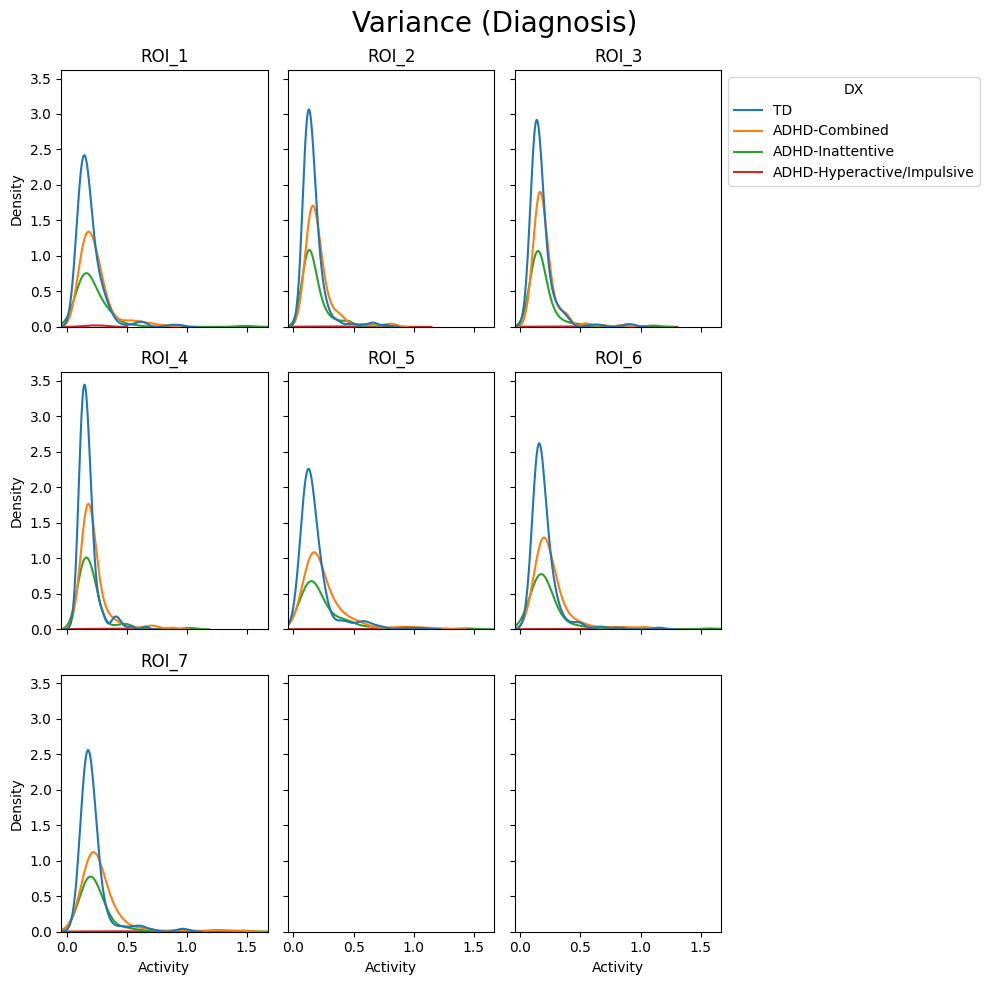

In [15]:
#Variance + diagnosis
plot_small_multiple_rois(data = var_pr_roi, regions = regions, title = 'Variance (Diagnosis)', hue_col = 'DX')

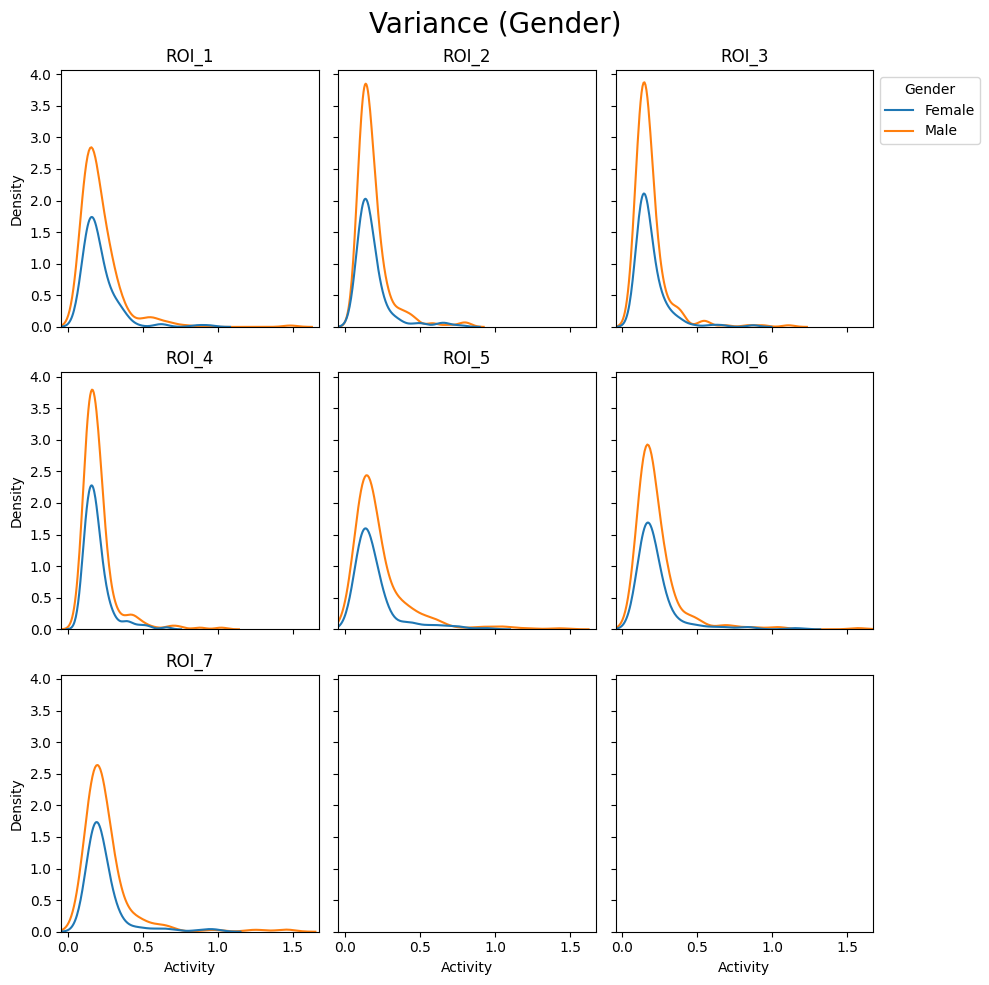

In [16]:
#Variance + gender
plot_small_multiple_rois(data = var_pr_roi, regions = regions, title = 'Variance (Gender)', hue_col = 'Gender')

### Mean

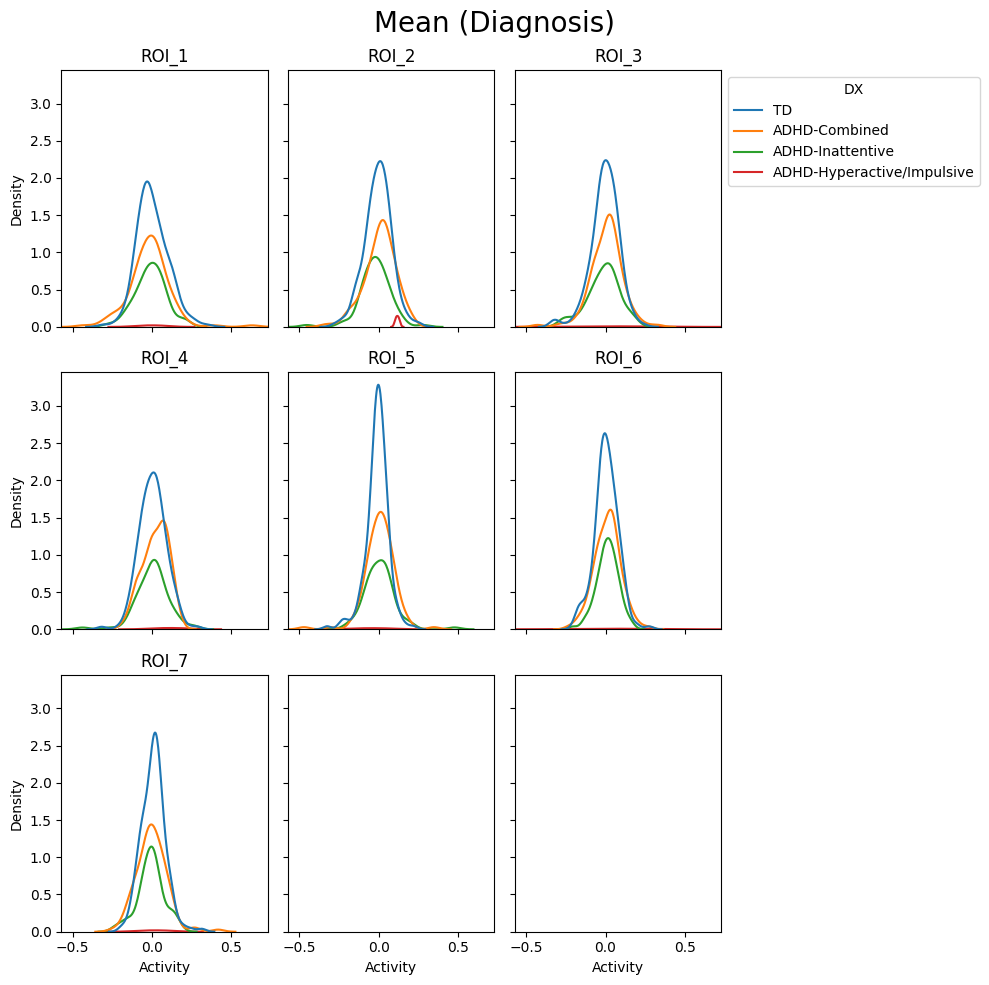

In [17]:
#Mean + diagnosis
plot_small_multiple_rois(data = mean_pr_roi, regions = regions, title = 'Mean (Diagnosis)', hue_col = 'DX')

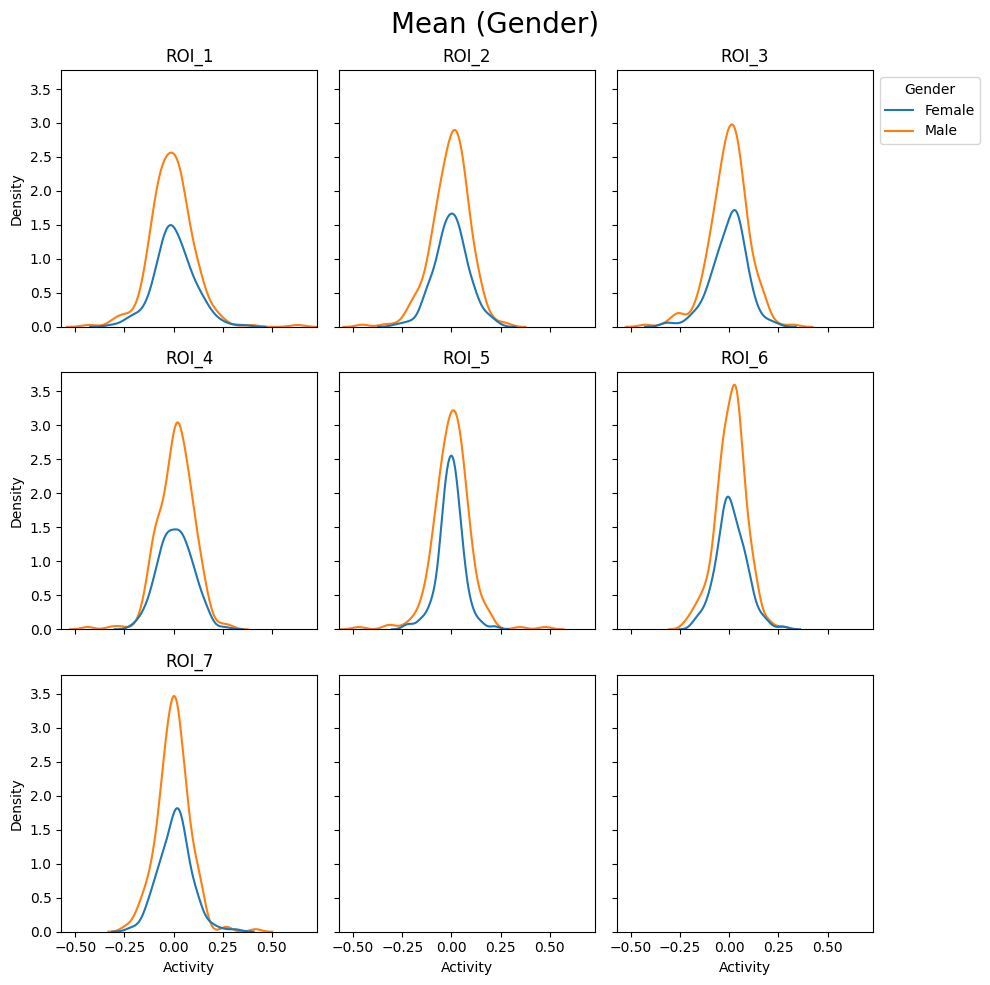

In [18]:
#Mean + gender
plot_small_multiple_rois(data = mean_pr_roi, regions = regions, title = 'Mean (Gender)', hue_col = 'Gender')

#### Check for different distributions (p-values)

##### Variance

In [19]:
print("-"*20,'Variance',"-"*20)
test_dist(data = var_pr_roi, regions = regions)
print('\n')
print("-"*10,'Without ADHD-Hyperactive/Impulsive',"-"*10)
test_dist(data = var_pr_roi[var_pr_roi['DX'] != 'ADHD-Hyperactive/Impulsive'], regions = regions)

-------------------- Variance --------------------
ROI_1 (Gender): The P-value is 0.6743549920770366
ROI_2 (Gender): The P-value is 0.722217411775731
ROI_3 (Gender): The P-value is 0.9620556397136294
ROI_4 (Gender): The P-value is 0.306207972262916
ROI_5 (Gender): The P-value is 0.05117370147501546
ROI_6 (Gender): The P-value is 0.699781637113893
ROI_7 (Gender): The P-value is 0.29147743001915577
##################################################
ROI_1 (Diagnosis): The P-value is 0.06485196034907989
ROI_2 (Diagnosis): The P-value is 0.0036266753477231105
ROI_3 (Diagnosis): The P-value is 0.03470861692494792
ROI_4 (Diagnosis): The P-value is 0.00044241829428505377
ROI_5 (Diagnosis): The P-value is 0.0019008312480209477
ROI_6 (Diagnosis): The P-value is 0.0014066460197229135
ROI_7 (Diagnosis): The P-value is 0.0010486217472796973


---------- Without ADHD-Hyperactive/Impulsive ----------
ROI_1 (Gender): The P-value is 0.6861958826492773
ROI_2 (Gender): The P-value is 0.7893540500073593
R

##### Mean

In [20]:
print("-"*20,'Mean',"-"*20)
test_dist(data = mean_pr_roi, regions = regions)

-------------------- Mean --------------------
ROI_1 (Gender): The P-value is 0.30202297868088296
ROI_2 (Gender): The P-value is 0.7095020185179262
ROI_3 (Gender): The P-value is 0.9268795689110686
ROI_4 (Gender): The P-value is 0.7850390850405696
ROI_5 (Gender): The P-value is 0.5500177783862223
ROI_6 (Gender): The P-value is 0.8462198991236103
ROI_7 (Gender): The P-value is 0.32817131354846374
##################################################
ROI_1 (Diagnosis): The P-value is 0.539105053676763
ROI_2 (Diagnosis): The P-value is 0.04094605787641839
ROI_3 (Diagnosis): The P-value is 0.43287005880729923
ROI_4 (Diagnosis): The P-value is 0.10034898954665433
ROI_5 (Diagnosis): The P-value is 0.259436856972716
ROI_6 (Diagnosis): The P-value is 0.782368318623146
ROI_7 (Diagnosis): The P-value is 0.5068113726170982


# Heatmaps

## Variance

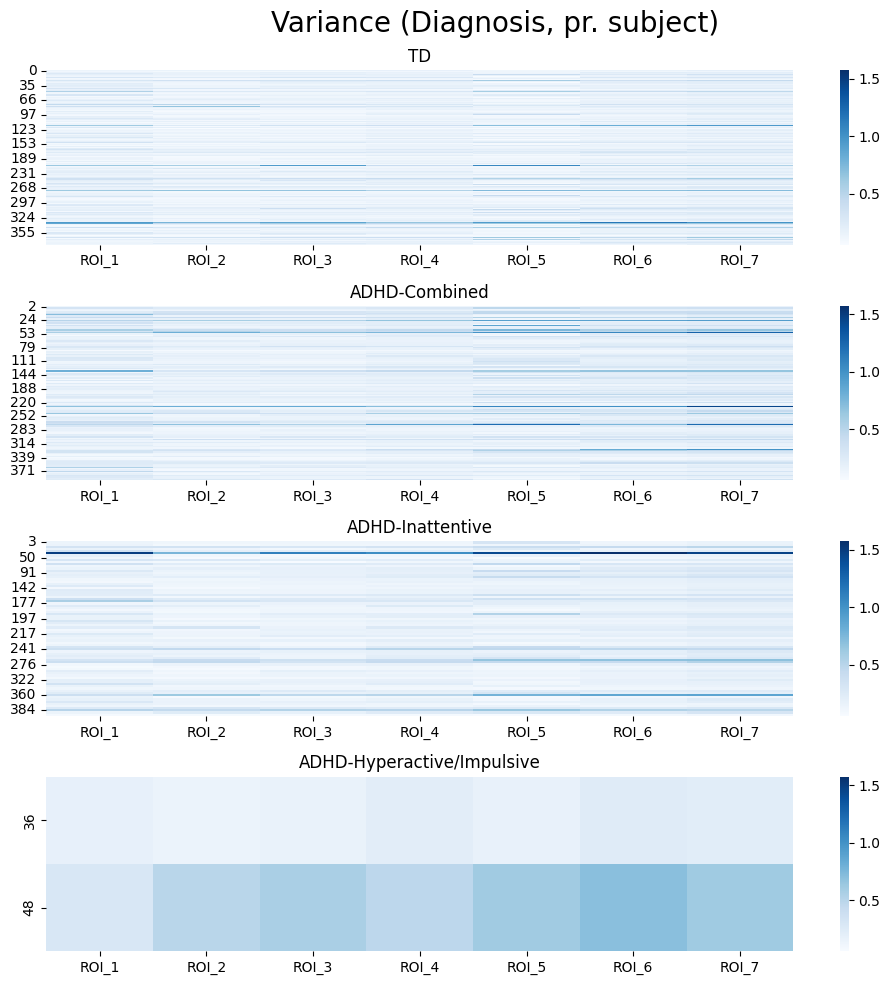

In [21]:
group_roi_heat_map(data = var_pr_roi, group = 'DX', title = 'Variance (Diagnosis, pr. subject)', regions = regions)

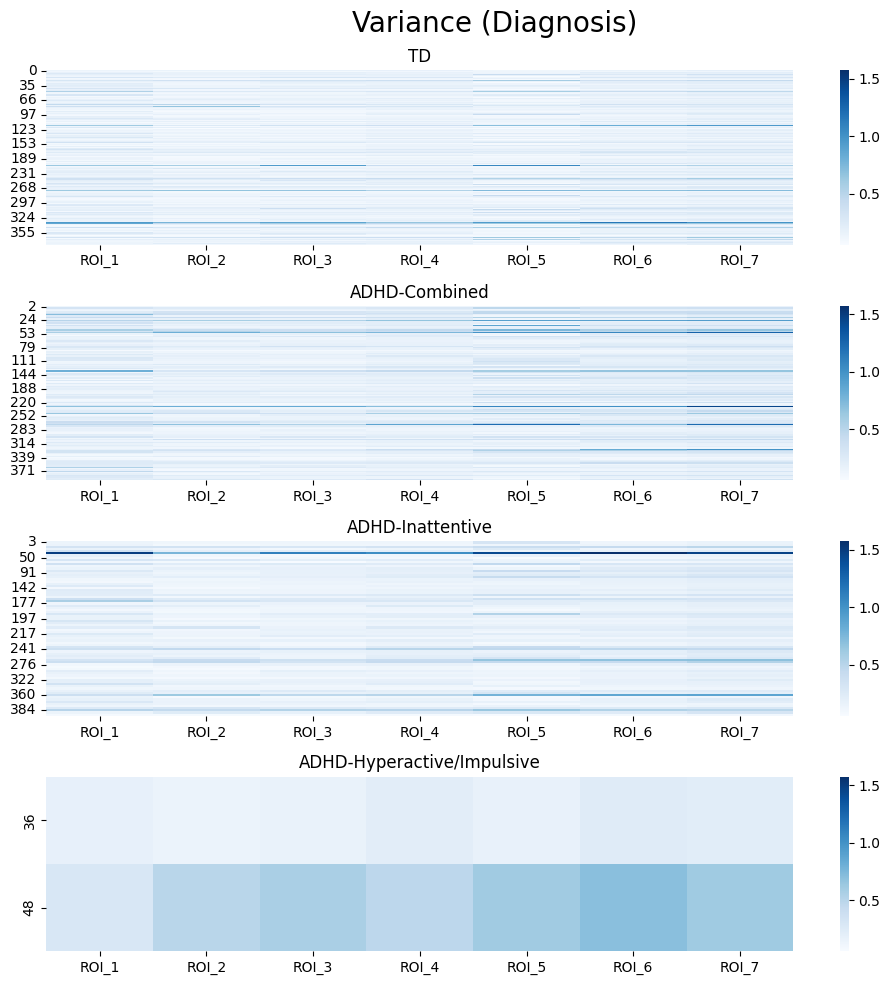

In [22]:
group_roi_heat_map(data = var_pr_roi, group = 'DX', title = 'Variance (Diagnosis)', regions = regions)

In [23]:
var_pr_roi

,Subject_ID,Session,Rest,ROI_1,ROI_2,ROI_3,ROI_4,ROI_5,ROI_6,ROI_7,ScanDir ID,Gender,DX
0,3662296,1,1,0.142888,0.150762,0.170962,0.185499,0.120572,0.163543,0.196198,3662296,Female,TD
1,0010097,1,1,0.113084,0.096357,0.092602,0.112406,0.127484,0.120382,0.131933,0010097,Female,TD
2,0010064,1,1,0.115571,0.093272,0.142835,0.129178,0.117899,0.159768,0.162086,0010064,Male,ADHD-Combined
3,0010056,1,2,0.141436,0.117431,0.131250,0.121396,0.311922,0.131031,0.156478,0010056,Male,ADHD-Inattentive
4,4562206,1,1,0.172666,0.162733,0.196089,0.171016,0.132022,0.225070,0.209657,4562206,Female,TD
...,...,...,...,...,...,...,...,...,...,...,...,...,...
388,3601861,1,1,0.219252,0.176213,0.144549,0.133189,0.094275,0.144759,0.145951,3601861,Female,ADHD-Combined
389,3349205,1,1,0.140984,0.239341,0.179246,0.242462,0.286837,0.243227,0.311321,3349205,Female,ADHD-Inattentive
390,2054438,1,2,0.238455,0.282816,0.255975,0.337184,0.191245,0.287595,0.353493,2054438,Male,ADHD-Combined
391,0010107,1,1,0.081131,0.071144,0.085435,0.083739,0.067047,0.097005,0.109105,0010107,Male,ADHD-Inattentive


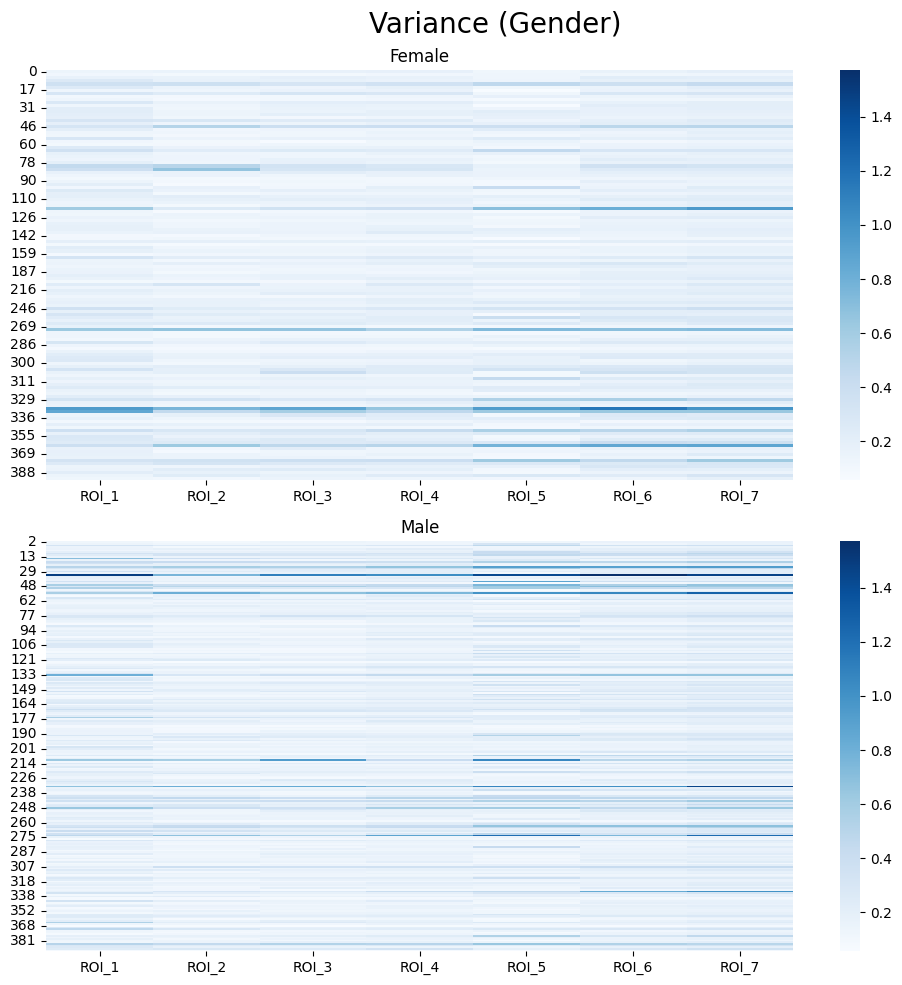

In [24]:
group_roi_heat_map(data = var_pr_roi, group = 'Gender', title = 'Variance (Gender)', regions = regions)

## Mean

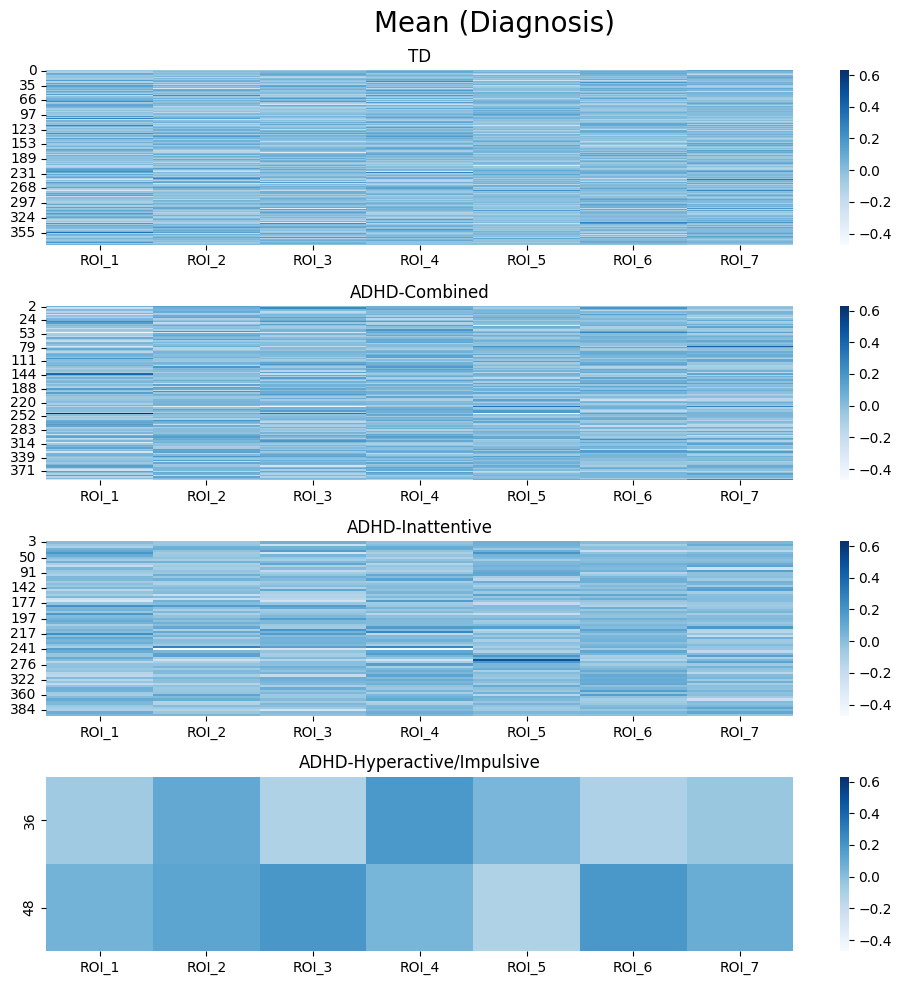

In [25]:
group_roi_heat_map(data = mean_pr_roi, group = 'DX', title = 'Mean (Diagnosis)', regions = regions)

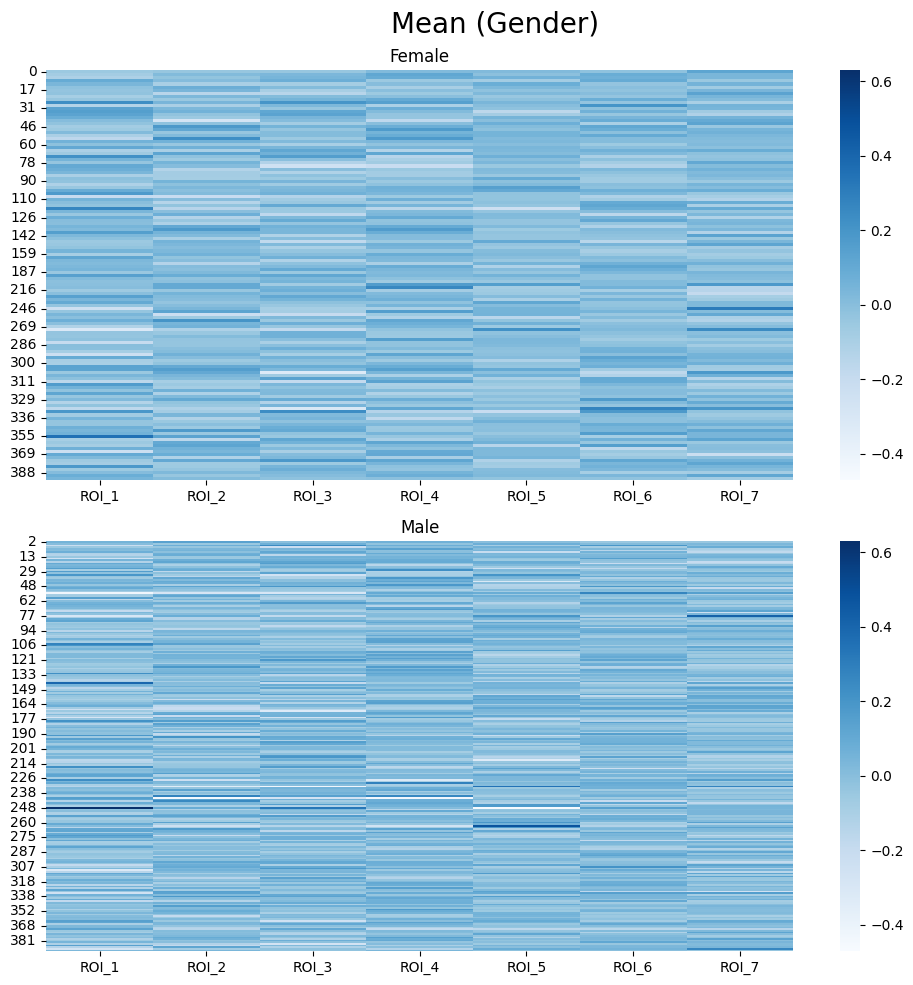

In [26]:
group_roi_heat_map(data = mean_pr_roi, group = 'Gender', title = 'Mean (Gender)', regions = regions)

## TODO
&#x2611; explore variance strangeness

&#x2611; explore means in same way
* Visualizing global patterns over time https://nilearn.github.io/dev/auto_examples/01_plotting/plot_carpet.html
* region activity over time https://nilearn.github.io/dev/auto_examples/06_manipulating_images/plot_nifti_labels_simple.html#sphx-glr-auto-examples-06-manipulating-images-plot-nifti-labels-simple-py


NameError: name 'means_pr_roi' is not defined

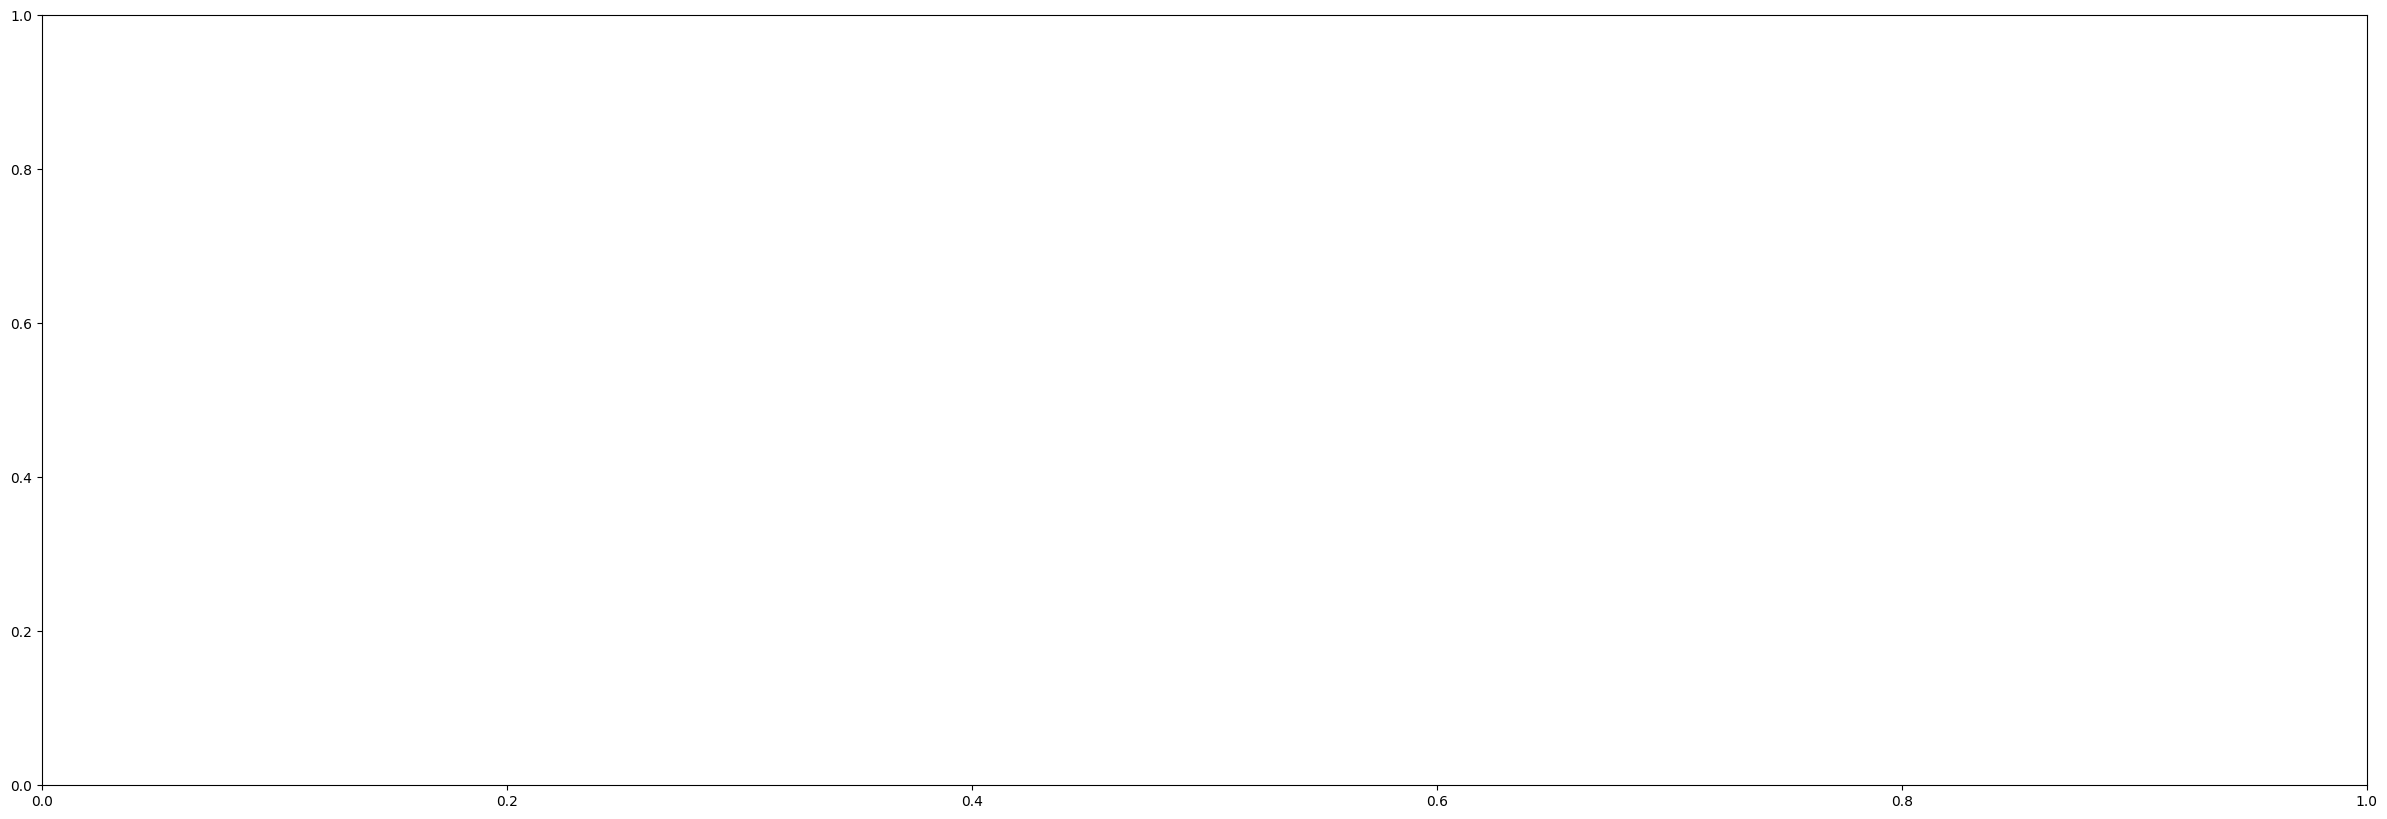

In [27]:
#WRONG! TODO fix, see below :)
fig = plt.figure(figsize=(30, 10))
ax = fig.add_subplot(111)


for i in means_pr_roi.loc[:, means_pr_roi.columns != "subject"]: #For each ROI 
    ax.plot(
        means_pr_roi[i], linewidth=2, label=i,alpha = 0.7
            ) #would be super cool to align the colour to a diagnosis #TODO exclude huge values

ax.legend(loc=2)
ax.set_title("Signals for first 3 regions")
plt.show()

In [ ]:
# for subject in tqdm(file_list): #For each subject

#     subject = np.load(f'data/clean/NYU/{subject}')
#     for i in subject.files: #For each ROI 
#         if i != "allow_pickle": #TODO fix, there is a strange "Allow pickle thing here sometimes??"
#             roi = subject[i]
#             values = pd.DataFrame()
#             #Get all values from each timestep
#             for t in range(roi.shape[0]):
#                 values[t] = roi[t] #appends
#     break
